In [1]:
import sys
sys.path.append("/home/klaus/dev/PyMesh/build/debug/py/mesh")
from pymesh import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.lines as mlines

def print_mesh(mesh, ax, r=0.01, c="black", z=1, lw=1.0):
    plt.xlabel("$r_\mathrm{x}$")
    plt.ylabel("$r_\mathrm{y}$")
    plt.rc('axes', linewidth=3)
    plt.rcParams.update({'font.size': 15})
    plt.tight_layout()
    ax.set_aspect(1)
    vertices = np.array([vertex.point(0) for vertex in mesh.vertices])
    edges = [(edge.point(0), edge.point(1)) for edge in mesh.edges]
    for vertex in vertices:
        ax.add_patch(pat.Circle(vertex, radius=r, color=c, fill=True, zorder=2))
    for p1, p2 in edges:
        # Ensure p1 and p2 are finite within valid ranges
        if not np.isfinite(p1[0]):
            p1 = np.array([np.sign(p1[0]) * -100.0, 0.0])
        elif not np.isfinite(p1[1]):
            p1 = np.array([p1[0], np.sign(p1[1]) * -100.0])
        if not np.isfinite(p2[0]):
            p2 = np.array([np.sign(p2[0]) * -100.0, 0.0])
        elif not np.isfinite(p2[1]):
            p2 = np.array([p2[0], np.sign(p2[1]) * -100.0])
        ax.add_patch(pat.Circle(p1, radius=r * 0.5, color=c, fill=True, zorder=3))
        ax.add_patch(pat.Circle(p2, radius=r * 0.5, color=c, fill=True, zorder=3))
        ax.add_line(mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]], c=c, lw=lw, zorder=z))

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_105910/1936890713.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$r_\mathrm{x}$")
/tmp/ipykernel_105910/1936890713.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$r_\mathrm{y}$")


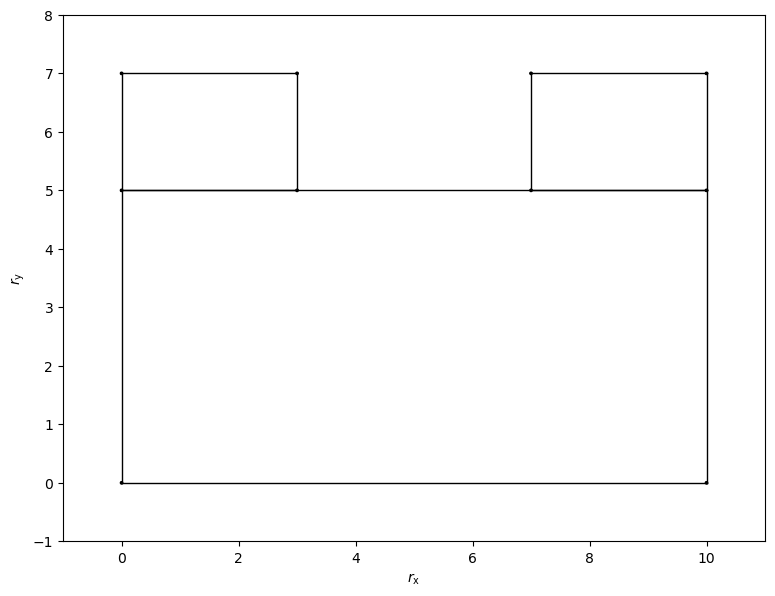

In [2]:
builder = SystemBuilder2D()
#                                   0            1            2            3           4           5            6          7           8           9
builder.add_vertices(np.array([[0.0, 0.0], [10.0, 0.0], [10.0, 5.0], [7.0, 5.0], [3.0, 5.0], [0.0, 5.0], [0.0, 7.0], [3.0, 7.0], [7.0, 7.0], [10.0, 7.0]]))\
.add_segment("bottom")\
    .add_edges([[0, 1], [1, 2], [2, 5], [5, 0]])\
.add_segment("left")\
    .add_edges([[5, 4], [4, 7], [7, 6], [6, 5]])\
.add_segment("right")\
    .add_edges([[3, 2], [2, 9], [9, 8], [8, 3]])

%matplotlib inline

f1 = plt.figure(figsize=(8,8))
ax = f1.gca()
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 8)
print_mesh(builder.mesh, ax, r=0.02, c="black")

In [3]:
system1 = builder.create(0.05, 32.0)

Meshing...
Constructing Delaunay triangulation by divide-and-conquer method.
  Sorting vertices.
  Forming triangulation.
  Removing ghost triangles.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
    Constructing mapping from vertices to triangles.
  Recovering PSLG segments.
  Enclosing convex hull with segments.
Segment milliseconds:  0
Removing unwanted triangles.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
  Looking for encroached subsegments.
  Making a list of bad triangles.
  Splitting bad triangles.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.
Writing Voronoi vertices.
Writing Voronoi edges.
Writing neighbors.

Output milliseconds:  0
Total running milliseconds:  2

Statistics:

  Input vertices: 10
  Input segments: 12
  Input holes: 0

  Mesh vertices: 1219
  Mesh triangles: 2306
  Mesh edges: 3524
  Mesh exterior boundary edges: 130
  Mesh interior boundary edges: 56
  Mesh subs

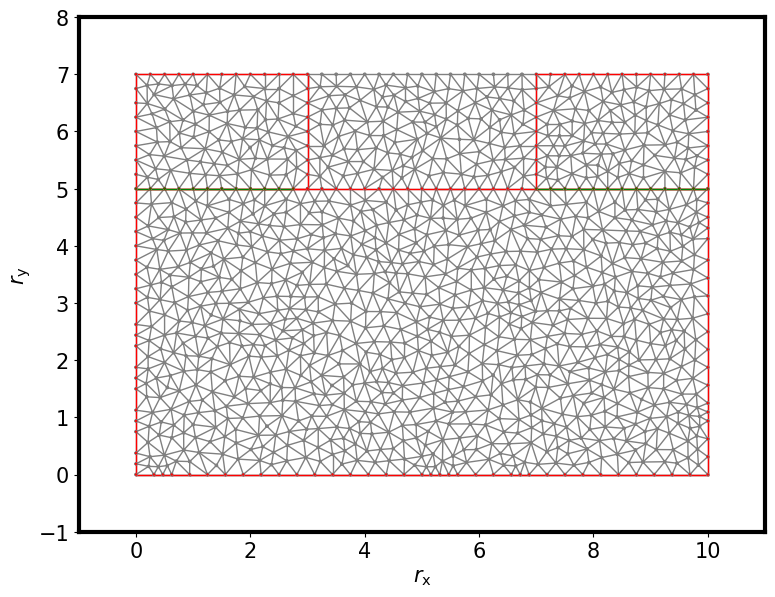

In [4]:
%matplotlib inline

f1 = plt.figure(figsize=(8,8))
ax = f1.gca()
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 8)
print_mesh(system1.mesh, ax, r=0.02, c="grey")
print_mesh(system1.surface("bottom").mesh, ax, r=0.01, c="red")
print_mesh(system1.surface("left").mesh, ax, r=0.01, c="red")
print_mesh(system1.surface("right").mesh, ax, r=0.01, c="red")
print_mesh(system1.interface("left", "bottom").mesh, ax, r=0.01, c="green")
print_mesh(system1.interface("right", "bottom").mesh, ax, r=0.01, c="green")

In [5]:
poisson = Poisson2D(system1)
dirichlet = set()
phi = system1.get_or_create_attribute(StorageLocation.VERTEX, "phi")
# Initialize values
for vertex in system1.mesh.vertices:
    phi[vertex.id] = 0.0
# Add surfaces vertices to Dirichlet boundary contion
for vertex in system1.surface("bottom").mesh.vertices:
    dirichlet.add(vertex.id)
for vertex in system1.surface("left").mesh.vertices:
    dirichlet.add(vertex.id)
for vertex in system1.surface("right").mesh.vertices:
    dirichlet.add(vertex.id)

# Set fixed potential for segment left and right
for vertex in system1.segment("left").mesh.vertices:
    phi[vertex.id] = 2.1
for vertex in system1.segment("right").mesh.vertices:
    phi[vertex.id] = -0.5
    
poisson.solve("phi", "E", [d for d in dirichlet])

nertices: 1219
kij: 13836
max_k: 1218
max_l: 1218
min_k: 0
min_l: 0


[Info, 12:27:54]: [Poisson] Pre-processing ...
[Info, 12:27:54]: [Poisson] Assembling ...threads) (37% - 0.0s - 1 threads)
[Info, 12:27:54]: [Poisson] Solving ...


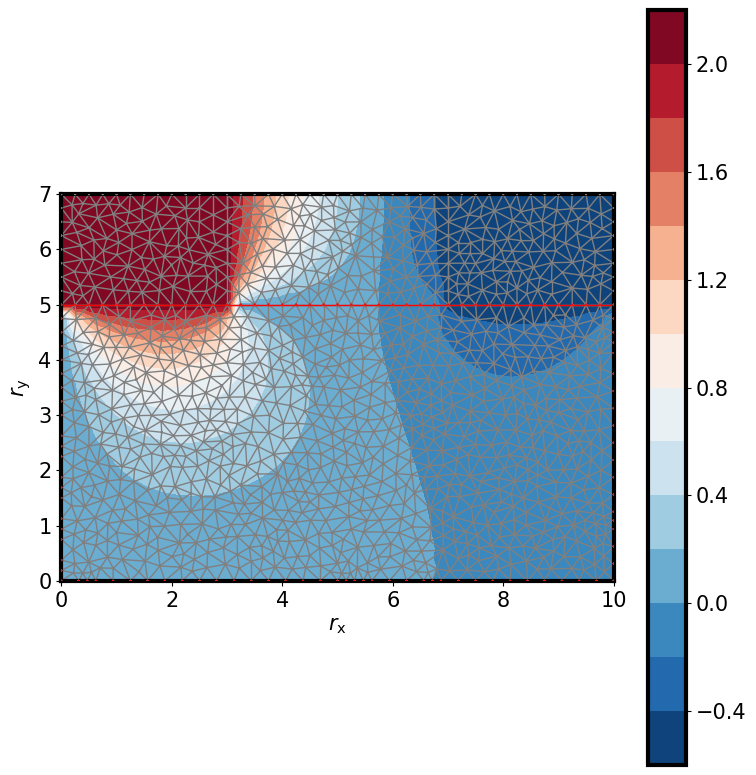

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri

n = len(system1.mesh.vertices)
Z_phi = np.empty((n))
X = np.empty((n))
Y = np.empty((n))
for i, vertex in enumerate(system1.mesh.vertices):
    Z_phi[i] =  phi[vertex.id]
    p = vertex.point(0)
    X[i] = p[0]
    Y[i] = p[1]
f1 = plt.figure(figsize=(8,8))
ax = f1.gca()
cs = ax.tricontourf(X, Y, Z_phi, levels=14, cmap="RdBu_r")
print_mesh(system1.mesh, ax, r=0.01, c="grey")
print_mesh(system1.surface("bottom").mesh, ax, r=0.01, c="red")
plt.colorbar(cs)

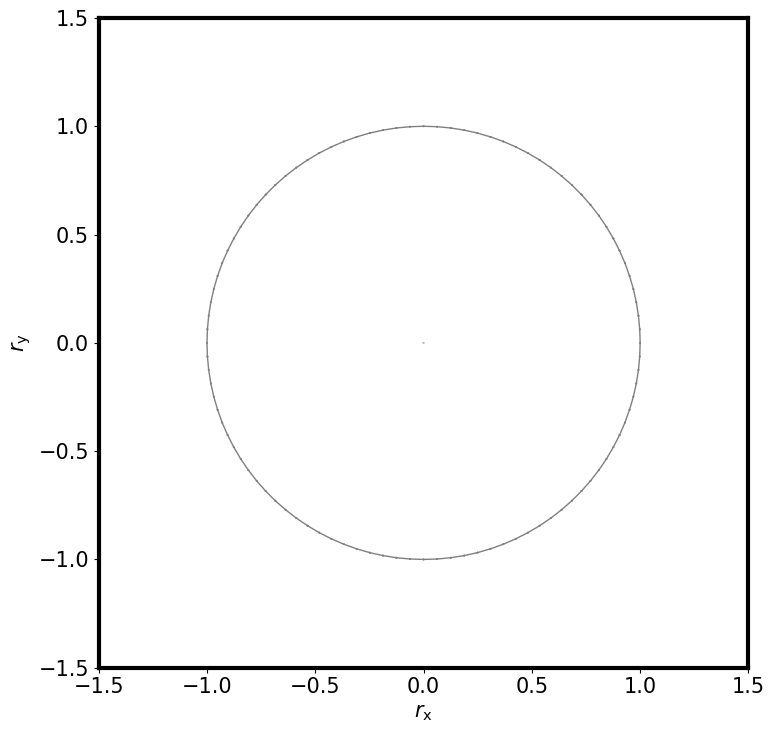

In [7]:
nsegs = 100
r = 1.0

vertices = np.array([*[[r * np.cos(2.0 * np.pi /nsegs * x), r * np.sin(2.0 * np.pi / nsegs * x)] for x in range(0, nsegs)], [0.0, 0.0]])
edges = np.array([[x % nsegs, (x + 1) % nsegs] for x in range(0, nsegs)])
builder2 = SystemBuilder2D()
builder2\
    .add_vertices(vertices)\
    .add_segment("circle")\
        .add_edges(edges)

%matplotlib inline

f1 = plt.figure(figsize=(8,8))
ax = f1.gca()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
print_mesh(builder2.mesh, ax, r=0.001, c="grey")

In [8]:
system2 = builder2.create(0.001, 32.0)

Meshing...
Constructing Delaunay triangulation by divide-and-conquer method.
  Sorting vertices.
  Forming triangulation.
  Removing ghost triangles.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
    Constructing mapping from vertices to triangles.
  Recovering PSLG segments.
  Enclosing convex hull with segments.
Segment milliseconds:  0
Removing unwanted triangles.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
  Looking for encroached subsegments.
  Making a list of bad triangles.
  Splitting bad triangles.
Quality milliseconds:  3

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.
Writing Voronoi vertices.
Writing Voronoi edges.
Writing neighbors.

Output milliseconds:  1
Total running milliseconds:  5

Statistics:

  Input vertices: 101
  Input segments: 100
  Input holes: 0

  Mesh vertices: 2670
  Mesh triangles: 5140
  Mesh edges: 7809
  Mesh exterior boundary edges: 198
  Mesh interior boundary edges: 0
  Mesh sub

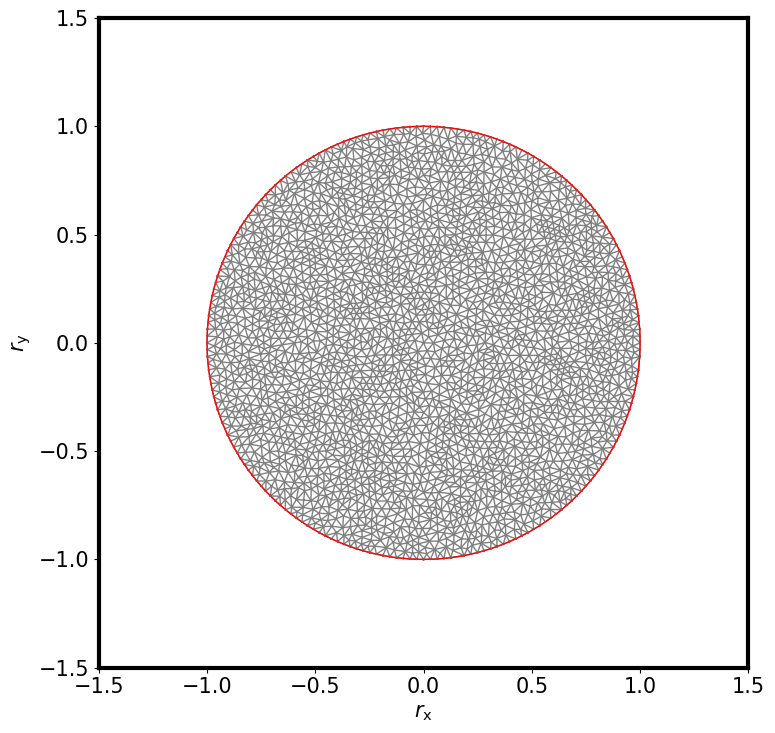

In [9]:
%matplotlib inline

f1 = plt.figure(figsize=(8,8))
ax = f1.gca()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
print_mesh(system2.mesh, ax, r=0.001, c="grey")
print_mesh(system2.surface("circle").mesh, ax, r=0.001, c="red")

In [10]:
poisson2 = Poisson2D(system2)
dirichlet2 = []
phi2 = system2.get_or_create_attribute(StorageLocation.VERTEX, "phi")
for vertex in system2.mesh.vertices:
    phi2[vertex.id] = 0.0
for vertex in system2.surface("circle").mesh.vertices:
    dirichlet2.append(vertex.id)
for vertex in system2.mesh.vertices:
    p = vertex.point(0)
    if ((np.abs(p[0]) < 1.0e-6) and (np.abs(p[1]) < 1.0e-6)):
        dirichlet2.append(vertex.id)
        phi2[vertex.id] = 1.0

poisson2.solve("phi", "E", dirichlet2)

nertices: 2670
kij: 30840
max_k: 2669
max_l: 2669
min_k: 0
min_l: 0


[Info, 12:29:19]: [Poisson] Pre-processing ...
[Info, 12:29:19]: [Poisson] Assembling ...threads)
[Info, 12:29:19]: [Poisson] Solving ...


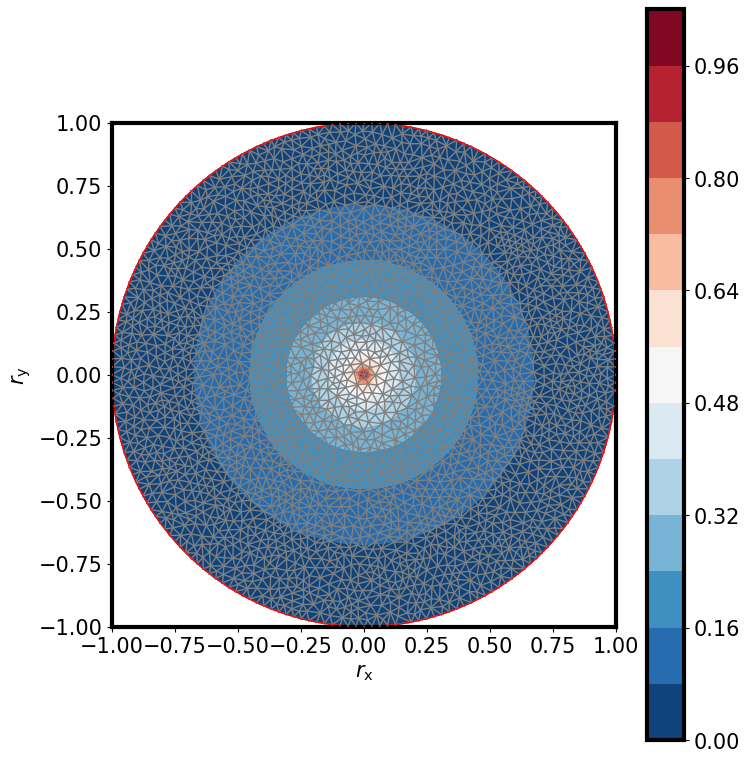

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri

n = len(system2.mesh.vertices)
Z2_phi = np.empty((n))
X2 = np.empty((n))
Y2 = np.empty((n))
for i, vertex in enumerate(system2.mesh.vertices):
    Z2_phi[i] =  phi2[vertex.id]
    p = vertex.point(0)
    X2[i] = p[0]
    Y2[i] = p[1] 
f1 = plt.figure(figsize=(8,8))
ax = f1.gca()
cs = ax.tricontourf(X2, Y2, Z2_phi, levels=14, cmap="RdBu_r")
print_mesh(system2.mesh, ax, r=0.001, c="grey")
print_mesh(system2.surface("circle").mesh, ax, r=0.001, c="red")
plt.colorbar(cs)